# Multi-Fidelity Bayesian Optimization: Investigating a Minimal Toy Problem

## Notes
We'll need to maintain a multioutput Gaussian Process surrogate for multifidelity Bayesian optimization. When using Gaussian Processes in the multifidelity scenario, one option is to extend the surrogate model through an autoregressive scheme:
$$
f^{(l)} = \rho f^{(l-1)}(\textbf{x}) + \delta^{l}(\textbf{x}), \;\; l = 2, \dots, L 
$$
where $\delta^{l}(\textbf{x}) \sim \mathcal{GP}(0, \kappa^{(l)}(\textbf{x}, \textbf{x}'))$ models the discrepancy between two adjoining levels of fidelity, and $\rho$ is a constant scaling factor.

## Desideratum
- [ ] We'll need a mechanism for computing covariances between input-fidelity pairs.
    - This poses a natural question: How do we choose our kernel function for evaluating the covariance between different fidelity levels?

## Minimal Problem Exploration
To make sense of the methodology presented in `Non-Myopic Multifidelity Bayesian Optimization`, we'll reduce our problem to the simplest instance of the generalized problem. That is, we only consider two fidelity measures via the autoregressive scheme:
$$
    f^{(2)} = \rho f^{(1)}(\textbf{x}) + \delta^{2}(\textbf{x})
$$

Given some arbitrary $\textbf{x}$, we know our 

## Surrogate and Kernel Setup

In [277]:
using Plots; plot() # warm start plotting engine
using LinearAlgebra
using Distributions

In [311]:
include("../src/testfns.jl")
include("../src/kernels.jl")
include("../src/surrogates.jl")

plot1d (generic function with 1 method)

## 1. Gather Initial Samples
Our first step is to run some initial experiments and collect our data locations into some matrix $X$ and observations into some vector $y$. Our "experiments" will be random evaluations of some test function; in practice, our function is black-boxed.

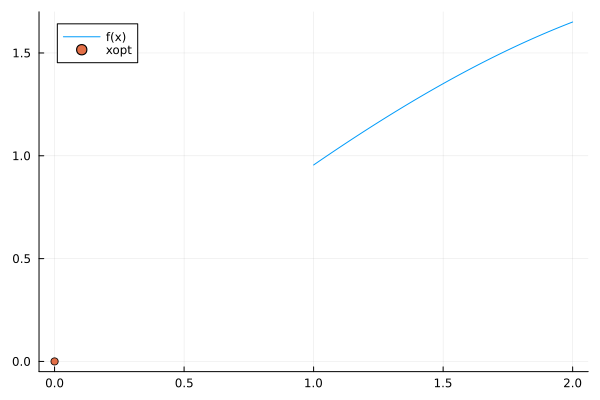

In [392]:
# testfn, testfn_name, X, y = get_toy_problem(N=7, fn_name="GramacyLee")
# println("Test Function: $(testfn_name)")

N = 3
ϵ = 1e-2
# testfn = TestAckley(1) + TestQuadratic1D(lb=-2., ub=2.)
testfn = TestLinearCosine1D(1., .3, lb=1., ub=2.)
X = randsample(N, testfn.dim, testfn.bounds[:, 1], testfn.bounds[:, 2])
y = testfn(X) .+ ϵ * randn(N)
tplot(testfn)

In [393]:
eigen(gram_matrix(Linear(1., 0.) + SquaredExponential(), X))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
3-element Vector{Float64}:
 0.002337464899202113
 0.145606973151504
 5.852055561949282
vectors:
3×3 Matrix{Float64}:
 -0.356434   0.738106   -0.572847
 -0.467219  -0.67176    -0.574844
  0.809112  -0.0627514  -0.584295

In [394]:
cholesky(gram_matrix(Linear(1., 0.) + SquaredExponential(), X))

Cholesky{Float64, Matrix{Float64}}
U factor:
3×3 UpperTriangular{Float64, Matrix{Float64}}:
 1.41421  1.31187   1.3798
  ⋅       0.528208  0.304265
  ⋅        ⋅        0.0597445

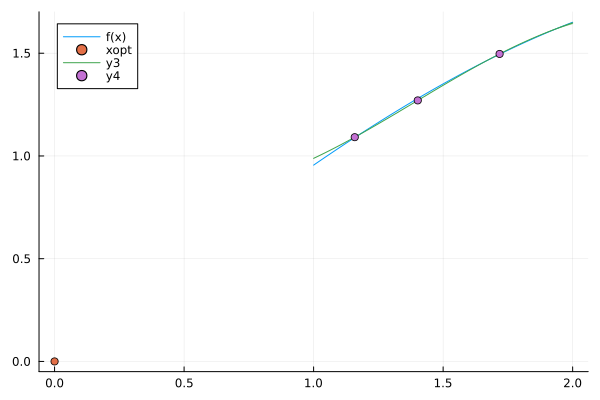

In [397]:
kernel = Linear(1., 0.) + SquaredExponential()
sur = ZeroMeanGP(kernel, X, y, noise=1e-6);

domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])
μ = [first(sur([x])) for x in domain]
σ = [sur([x])[2] for x in domain]

tplot(testfn)

# for _ in 1:50
#     normal_sample = randn()
#     plot!(domain, [([x], normal_sample) ~ sur for x in domain], label=nothing)
# end

plot!(domain, μ, ribbons=2σ)
scatter!(sur.X', get_observations(sur))

## On Computing and Optimizing Acquisition Functions

## On Modeling Separable Gaussian Processes via Additive Kernels
Given a random process $f(x) = f_1(x) + f_2(x)$, where $f_1, f_2$ are independent, then $k(x, y) = k_1(x, y) + k_2(x, y)$. Given a kernel $k: \chi^2 \to \mathbb{R}$ where $\chi \subset \mathbb{R}^d$ we know that adding a kernel or multiplying by a kernel results in another kernel.

In [154]:
kernels = [
    SquaredExponential(.5),
    SquaredExponential(.25),
    SquaredExponential(2.5),
    # Periodic(.5, .5),
]
kernel = sum(kernels)
surs = []
noise = 0.

for (i, k) in enumerate(kernels)
    noise_i = Int(i - 1 <= 0) * noise
    push!(surs, ZeroMeanGP(k, X, y; noise=noise_i))
end

sur = ZeroMeanGP(kernel, X, y; noise=noise);

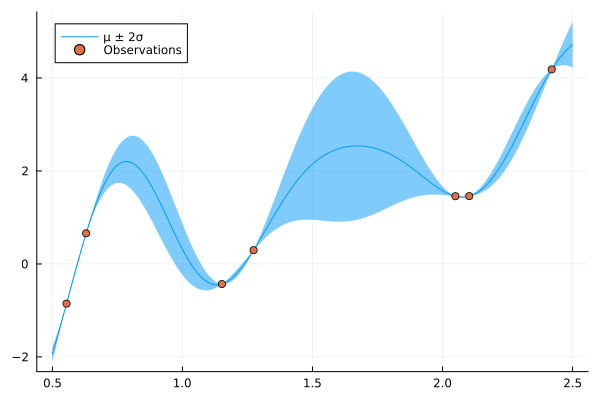

In [155]:
plot1d(sur, interval=domain)

## Experimental Below: On Automatic Differentiation of Kernel Hyperparameters
### Things to Resolve
1. There is a discrepancy between the GP fit to the sum of the kernels and the sum of the GPs fit to each kernel respectively. Investigate what is going on here.

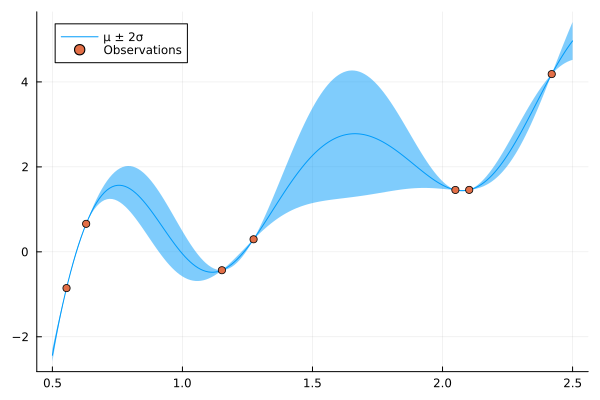

In [159]:
fx = zeros(length(domain))
stdx = zeros(length(domain))
normal_sample = randn()
μxs = zeros(length(surs))
σxs = zeros(length(surs))

for (i, x) in enumerate(domain)
    for (j, sur_j) in enumerate(surs)
        μxs[j], σxs[j] = sur_j([x])
    end

    μx, σx = sum(μxs), sum(σxs)

    fx[i] = μx / length(surs)
    stdx[i] = sqrt(σx)
end

p = plot(domain, fx, ribbons=2stdx, label="μ ± 2σ")
scatter!(surs[1].X', get_observations(surs[1]), label="Observations")

In [10]:
# Let's visualize several different initializations of the squared exponential
# kernel with different lengthscales
lengthscales = [1.]
kernels = [SquaredExponential(l) for l in lengthscales]
# gram_matrix(SquaredExponential(1.), X, noise=2.)
domain = -3.:.01:3.
dk = dkernel(SquaredExponential, lengthscales)

plot()
for (i, kernel) in enumerate(kernels)
    plot!(domain, [kernel([x], [0.]) for x in domain], label="Lengthscale = $(lengthscales[i])")
    plot!(domain, [first(dk([x], [0.])) for x in domain], label="dkdθ")
    # plot!(domain, [kernel([x], [0.]) - first(dk([x], [0.])) for x in domain], label="Δ")
end
plot!()

LoadError: UndefVarError: `dkernel` not defined

In [23]:
function UCB(sur::ZeroMeanGaussianProcess)
    function UCBx(x::AbstractVector; β=3.)
        μx, σx = sur(x)

        return μx + β*σx
    end

    return UCBx
end

UCB (generic function with 1 method)

In [41]:
kernel2 = Periodic(.87, 3.14)
sur2 = ZeroMeanGP(kernel2, X, y, noise=1e-6);

In [42]:
UCBx = UCB(sur)
UCBx2 = UCB(sur2)

UCBx (generic function with 1 method)

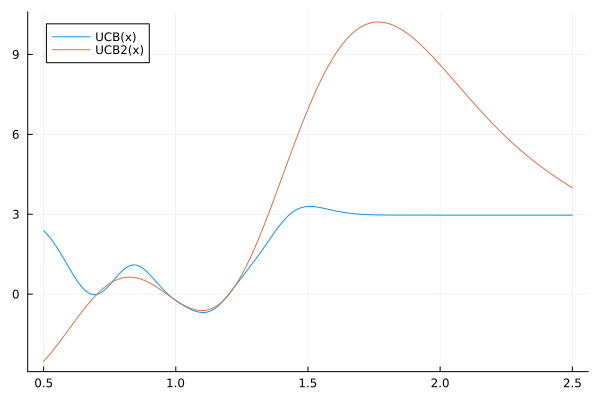

In [43]:
domain = first(testfn.bounds[:, 1]):.01:first(testfn.bounds[:, 2])

plot(domain, [UCBx([x]) for x in domain], label="UCB(x)")
plot!(domain, [UCBx2([x]) for x in domain], label="UCB2(x)")

## Delete Below

In [13]:
using ForwardDiff

In [14]:
ForwardDiff.gradient

gradient (generic function with 4 methods)

In [15]:
function SquaredExponential(lengthscales::AbstractVector)
    function squared_exponential(x, y)
        M = Diagonal(lengthscales .^ -2)
        r = x - y
        d = dot(r', M, r)
        return exp(-.5d)
    end

    return Kernel(lengthscales, squared_exponential)
end

SquaredExponential (generic function with 2 methods)

In [16]:
θs = [1.]

function dkernel(k_constructor::Function, θ::AbstractVector)
    ∇θ_ψ(x, y) = ForwardDiff.gradient(θ -> k_constructor(θ)(x, y), θ)
    
    return ∇θ_ψ
end

dkernel (generic function with 1 method)

In [17]:
dkernel(SquaredExponential, θs)([1.], [1.1])

1-element Vector{Float64}:
 0.009950124791926841